In [1]:
data_path = "/scratch/cl6707/Shared_Datasets/NSD_MindEye"
nsd_root = "/scratch/cl6707/Projects/neuro_interp/data/NSD/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"
nsd_mindroot = '/scratch/cl6707/Shared_Datasets/NSD_MindEye'

subj = 1
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
import sys
sys.path.append('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsd')
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from tqdm.notebook import tqdm
import webdataset as wds

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
local_rank = 0
print("device:",device)

import utils
from models import Clipper, OpenClipper, BrainNetwork, BrainDiffusionPrior, BrainDiffusionPriorOld, Voxel2StableDiffusionModel, VersatileDiffusionPriorNetwork

if utils.is_interactive():
    %load_ext autoreload
    %autoreload 2

seed=42
utils.seed_everything(seed=seed)

from torch.utils.data import Dataset
%matplotlib inline
fpX = np.float32
from src.file_utility import load_mask_from_nii, view_data

import h5py
import glob
import torchvision.models as models
from sklearn.decomposition import PCA
from PIL import Image
import nibabel as nib
from scipy.stats import pearsonr
import tensorflow as tf
import tensorflow_hub as hub
guse = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

subj =1
voxel_roi_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%subj)

if subj == 1:
    num_voxels = 15724
elif subj == 2:
    num_voxels = 14278
elif subj == 3:
    num_voxels = 15226
elif subj == 4:
    num_voxels = 13153
elif subj == 5:
    num_voxels = 13039
elif subj == 6:
    num_voxels = 17907
elif subj == 7:
    num_voxels = 12682
elif subj == 8:
    num_voxels = 14386

device: cuda


2023-12-03 22:25:08.922481: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 22:25:09.633244: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 22:25:10.545796: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 22:25:10.545863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 22:25:10.590040: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
print('Pulling NSD webdataset data...')
# Multi-GPU config #
from accelerate import Accelerator
accelerator = Accelerator(split_batches=False,mixed_precision='fp16')  
print("PID of this process =",os.getpid())
print = accelerator.print # only print if local_rank=0
device = accelerator.device
print("device:",device)
num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1
num_workers = num_devices
print(accelerator.state)
local_rank = accelerator.state.local_process_index
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size)



train_url = "{" + f"{data_path}/webdataset_avg_split/train/train_subj0{subj}_" + "{0..17}.tar," + f"{data_path}/webdataset_avg_split/val/val_subj0{subj}_0.tar" + "}"
val_url = f"{data_path}/webdataset_avg_split/test/test_subj0{subj}_" + "{0..1}.tar"
print(train_url,"\n",val_url)
meta_url = f"{data_path}/webdataset_avg_split/metadata_subj0{subj}.json"
num_train = 8559 + 300
num_val = 982
batch_size = 16
print('Prepping train and validation dataloaders...')
train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
    batch_size,'images',
    num_devices=num_devices,
    num_workers=num_workers,
    train_url=train_url,
    val_url=val_url,
    meta_url=meta_url,
    num_train=num_train,
    num_val=num_val,
    val_batch_size=300,
    cache_dir=data_path, #"/tmp/wds-cache",
    seed=seed,
    voxels_key='nsdgeneral.npy', # 'nsdgeneral.npy' (1d), 'wholebrain_3d.npy'(3d)
    to_tuple=["voxels", "images", "coco","trial"],
    local_rank=local_rank,
    world_size=world_size,
)

Pulling NSD webdataset data...
PID of this process = 402102
device: cuda
Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1
{/scratch/cl6707/Shared_Datasets/NSD_MindEye/webdataset_avg_split/train/train_subj01_{0..17}.tar,/scratch/cl6707/Shared_Datasets/NSD_MindEye/webdataset_avg_split/val/val_subj01_0.tar} 
 /scratch/cl6707/Shared_Datasets/NSD_MindEye/webdataset_avg_split/test/test_subj01_{0..1}.tar
Prepping train and validation dataloaders...
Getting dataloaders...

num_train 8859
global_batch_size 16
batch_size 16
num_workers 1
num_batches 553
num_worker_batches 553

num_val 982
val_num_batches 61
val_batch_size 300


In [3]:
annotation_all = np.load(nsd_mindroot + '/subj%02d_annot.npy'%subj,allow_pickle=True)
nsdgeneral_affine = nib.load('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/roi/nsdgeneral.nii.gz').affine
nsdgeneral_roi_mask = nib.load('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/roi/nsdgeneral.nii.gz').get_fdata()==1
anat_img = '/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/T1_to_func1pt8mm.nii.gz'
from torchvision import models
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1]).to(device)
resnet = resnet.eval()
from transformers import GPT2Tokenizer, GPT2Model
tokenizer_gpt = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer_gpt.pad_token = tokenizer_gpt.eos_token
gpt = GPT2Model.from_pretrained('gpt2').to(device)
gpt = gpt.eval()


def reconstruct_volume_corrected(vol_shape, binary_mask, data_vol, order='C'):
    
    view_vol = np.ones(np.prod(vol_shape), dtype=np.float32) * np.nan
    
    idx_mask = np.where(binary_mask)[0]
    
    view_vol[idx_mask] = data_vol
    return view_vol.reshape(vol_shape, order=order)

@torch.no_grad()
def get_guse(annotation,mode='max'):
    B = annotation.shape[0]
    annot_embed_all = np.zeros((B,512))
    if mode == 'max':
        for b in range(B):
            annot_embed = guse(annotation[b][0]).cpu().numpy()
            corr_mat = np.corrcoef(annot_embed)
            max_index = np.argmax(corr_mat.mean(axis=0),axis=0)
            annot_embed_all[b] = annot_embed[max_index]
    elif mode == 'mean':
        for b in range(B):
            annot_embed = guse(annotation[b][0]).cpu().numpy()
            annot_embed_all[b] = annot_embed.mean(axis=0)
    else:
        raise NotImplementedError
    
    return torch.tensor(annot_embed_all).to(device).float()

@torch.no_grad()
def get_resnet(images):
    resize_normalize = transforms.Compose([
                        transforms.Resize(224),  # Resize to 224x224
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ])
    images = torch.stack([resize_normalize(img) for img in images]).to(device)
    features = resnet(images)
    return features.squeeze(-1).squeeze(-1)

/ext3/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ext3/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Linear Mapping Model

In [4]:
import torch
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size, alpha, l1_ratio):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.alpha = alpha
        self.l1_ratio = l1_ratio

    def forward(self, x):
        return self.linear(x)

    def tv_l1_regularization(self):
        weights = self.linear.weight
        grad_x = torch.abs(weights[:, 1:] - weights[:, :-1])
        grad_y = torch.abs(weights[1:, :] - weights[:-1, :])
        tv_norm = torch.sum(grad_x) + torch.sum(grad_y)
        l1_norm = torch.sum(torch.abs(weights))
        return self.l1_ratio * tv_norm + (1 - self.l1_ratio) * l1_norm

### train the model

In [ ]:
model = LinearModel(num_voxels, 512,1,0.5, None)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

from scipy.stats import pearsonr
loss_dict_train = {'tv_l1':[],
                'mse':[]
                }
tv_weight = 1e-3
pcc_list_train = []

epoch_num = 10
for epoch in tqdm(range(epoch_num)):
    for voxels, images, coco, trial in train_dl:
        pcc_all = []
        voxels = voxels.float().to(device)
        voxels = voxels.mean(axis=1)
        guse_embed = get_guse(annotation_all[trial])
        optimizer.zero_grad()
        outputs = model(voxels)
        tv_l1 = model.tv_l1_regularization()
        mse = criterion(outputs, guse_embed)
        loss_dict_train['tv_l1'].append(tv_l1.item()*tv_weight)
        loss_dict_train['mse'].append(mse.item())
        loss = mse + tv_weight*tv_l1
        loss.backward() 
        optimizer.step()
        # calculte PCC between outputs and guse_embed
        pcc = [pearsonr(outputs[i].detach().cpu().numpy(), guse_embed[i].detach().cpu().numpy(),)[0] for i in range(len(outputs))]
        pcc_all += pcc
    pcc_list_train.append(np.mean(pcc_all))

100%|██████████| 10/10 [16:33<00:00, 99.34s/it]


### Load model

In [4]:
model = LinearModel(num_voxels, 512,1,0.5, None)
model.load_state_dict(torch.load('./output/subj%02d_linear_model.pt'%subj))
model.to(device)

LinearModel(
  (linear): Linear(in_features=15724, out_features=512, bias=True)
)

In [7]:
loss_dict_val = {'tv_l1':[],
                'mse':[]
                }
pcc_list_val = []

model.eval()
for voxels, images, coco, trial in val_dl:
    voxels = voxels.float().to(device)
    voxels = voxels.mean(axis=1)
    guse_embed = get_guse(annotation_all[trial])
    outputs = model(voxels)
    # tv_l1 = model.tv_l1_regularization()
    # mse = criterion(outputs, guse_embed)
    # loss_dict_val['tv_l1'].append(tv_l1.item())
    # loss_dict_val['mse'].append(mse.item())
    # loss = mse + tv_weight*tv_l1
    # calculte PCC between outputs and guse_embed
    pcc = [pearsonr(outputs[i].detach().cpu().numpy(), guse_embed[i].detach().cpu().numpy(),)[0] for i in range(len(outputs))]
    pcc_list_val += pcc

print('Val PCC:',np.mean(pcc_list_val))
# save model
# torch.save(model.state_dict(), './output/subj%02d_linear_model.pt'%subj)

Instructions for updating:
Use tf.identity with explicit device placement instead.


Instructions for updating:
Use tf.identity with explicit device placement instead.


Val PCC: 0.45475639039702076


### Visualize weight

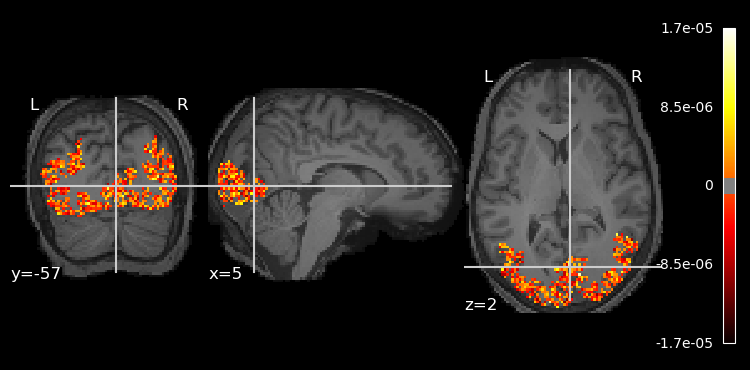

In [8]:
weights = model.linear.weight.detach().cpu().numpy()
weights = weights.mean(axis=0)
voxel_weight = weights
reconstructed_weight = reconstruct_volume_corrected(nsdgeneral_roi_mask.shape, nsdgeneral_roi_mask.flatten(), voxel_weight)
reconstructed_weight = np.nan_to_num(reconstructed_weight)
ni_img = nib.Nifti1Image(reconstructed_weight,affine=nsdgeneral_affine)
from nilearn.plotting import plot_stat_map
plot_stat_map(ni_img,
                bg_img=anat_img,
                    cmap='hot')

### oclussion on voxel

In [45]:
epoch_num = 10
tv_weight = 1e-3
# weights for each voxel
weights = model.linear.weight.detach().cpu().numpy()
weights = weights.mean(axis=0)
voxel_weight = weights
# get top 10 voxels by absolute value
top_n = 10000
top_voxel = np.argsort(np.abs(voxel_weight))[::-1][:top_n].tolist()
model_oc = LinearModel(num_voxels, 512,1,0.5, None).to(device)
optimizer_oc = torch.optim.Adam(model_oc.parameters(), lr=1e-3)
criterion = nn.MSELoss()
# for each voxel in the top10, mask out it and train the model again, see if the performance drops
pcc_voxel_dict = {}

for epoch in tqdm(range(epoch_num)):
    for voxels, images, coco, trial in train_dl:
        pcc_all = []
        voxels = voxels.float().to(device)
        voxels = voxels.mean(axis=1)
        voxels[:,top_voxel] = 0
        guse_embed = get_guse(annotation_all[trial])
        optimizer_oc.zero_grad()
        outputs = model_oc(voxels)
        tv_l1 = model_oc.tv_l1_regularization()
        mse = criterion(outputs, guse_embed)
        loss = mse + tv_weight*tv_l1
        loss.backward() 
        optimizer_oc.step()

pcc_list_val = []

model_oc.eval()
for voxels, images, coco, trial in val_dl:
    voxels = voxels.float().to(device)
    voxels = voxels.mean(axis=1)
    # voxels[:,top_voxel] = 0
    guse_embed = get_guse(annotation_all[trial])
    outputs = model_oc(voxels)
    tv_l1 = model_oc.tv_l1_regularization()
    mse = criterion(outputs, guse_embed)
    # loss_dict_val['tv_l1'].append(tv_l1.item())
    # loss_dict_val['mse'].append(mse.item())
    loss = mse + tv_weight*tv_l1
    # calculte PCC between outputs and guse_embed
    pcc = [pearsonr(outputs[i].detach().cpu().numpy(), guse_embed[i].detach().cpu().numpy(),)[0] for i in range(len(outputs))]
    pcc_list_val += pcc

print('Val PCC:',np.mean(pcc_list_val))
pcc_voxel_dict = np.mean(pcc_list_val)
# save model
torch.save(model_oc.state_dict(), './output/voxel_occlusion/subj%02d_linear_model_oc%04d.pt'%(subj,top_n))


  0%|          | 0/10 [00:00<?, ?it/s]

Val PCC: 0.4486792816595214


# Visual embedding

In [5]:
visual_linear = LinearModel(num_voxels, 2048,1,0.5).to(device)
optimizer_visual = torch.optim.Adam(visual_linear.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epoch_num = 10
tv_weight = 1e-3

for epoch in tqdm(range(epoch_num)):
    for voxels, images, coco, trial in train_dl:
        pcc_all = []
        voxels = voxels.float().to(device)
        voxels = voxels.mean(axis=1)
        visual_embed = get_resnet(images)
        optimizer_visual.zero_grad()
        outputs = visual_linear(voxels)
        tv_l1 = visual_linear.tv_l1_regularization()
        mse = criterion(outputs, visual_embed)
        loss = mse + tv_weight*tv_l1
        loss.backward() 
        optimizer_visual.step()

pcc_list_val = []

visual_linear.eval()

for voxels, images, coco, trial in val_dl:
    voxels = voxels.float().to(device)
    voxels = voxels.mean(axis=1)
    visual_embed = get_resnet(images)
    outputs = visual_linear(voxels)
    tv_l1 = visual_linear.tv_l1_regularization()
    mse = criterion(outputs, visual_embed)
    loss = mse + tv_weight*tv_l1
    # calculte PCC between outputs and guse_embed
    pcc = [pearsonr(outputs[i].detach().cpu().numpy(), visual_embed[i].detach().cpu().numpy(),)[0] for i in range(len(outputs))]
    pcc_list_val += pcc

print('Val PCC:',np.mean(pcc_list_val))
pcc_visual_dict = np.mean(pcc_list_val)

# save model
torch.save(visual_linear.state_dict(), './output/subj%02d_linear_model_visual.pt'%subj)

  0%|          | 0/10 [00:00<?, ?it/s]

/ext3/miniconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Val PCC: 0.30850367590094974


RuntimeError: Parent directory ./output/visual_linear does not exist.

## weights visualization

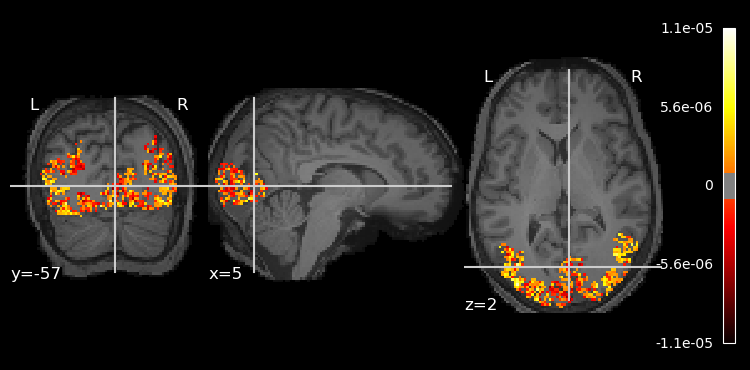

In [7]:
weight = visual_linear.linear.weight.detach().cpu().numpy()
weight = weight.mean(axis=0)
reconstructed_weight = reconstruct_volume_corrected(nsdgeneral_roi_mask.shape, nsdgeneral_roi_mask.flatten(), weight)
reconstructed_weight = np.nan_to_num(reconstructed_weight)
ni_img = nib.Nifti1Image(reconstructed_weight,affine=nsdgeneral_affine)
from nilearn.plotting import plot_stat_map
plot_stat_map(ni_img,
                bg_img=anat_img,
                    cmap='hot')
                    